BMI categories dataset (first 10,000 rows) created successfully!
Error loading image A:/PRML_project/side/side\A00220.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/side/side\A56106.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/side/side\A61982.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/side/side\A70618.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/side/side\A81652.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/side/side\A81850.jpg: cannot identify image file <_io.BytesIO object at 0x000002734F678A90>
Error loading image A:/PRML_project/side/side\A82134.jpg: cannot identify image file <_io.BytesIO object at 0x00000273501D41D0>
Error loading image A:/PRML_project/sid

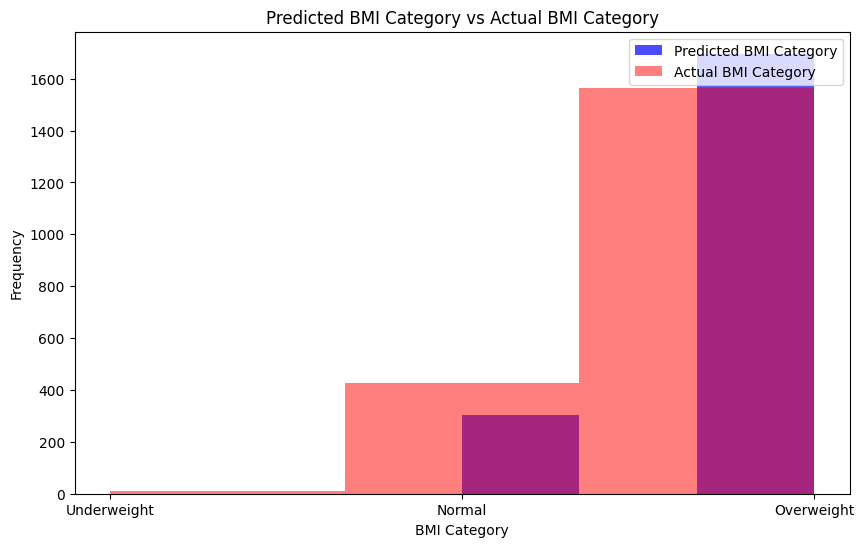

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('person.csv', delimiter=';')

# Convert weight (pounds to kilograms) and height (inches to meters)
df['Weight_kg'] = df['weight'] * 0.453592  # 1 pound = 0.453592 kg
df['Height_m'] = df['height'] * 0.0254    # 1 inch = 0.0254 meters

# Calculate BMI
df['BMI'] = df['Weight_kg'] / (df['Height_m'] ** 2)

# Categorize BMI
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    else:
        return 'Overweight'

df['Category'] = df['BMI'].apply(bmi_category)

# Create a new dataset with only the ID and Category columns
bmi_df = df[['id', 'Category']]

# Use only the first 10,000 rows
bmi_df = bmi_df.head(10000)

# Save the new dataset
bmi_df.to_csv('bmi.csv', index=False)

print("BMI categories dataset (first 10,000 rows) created successfully!")

# Load dataset
file_path = 'bmi.csv'
labels_df = pd.read_csv(file_path).head(10000)

# Map categories to numeric labels
class_mapping = {'Underweight': 0, 'Normal': 1, 'Overweight': 2}
labels_df['class_label'] = labels_df['Category'].map(class_mapping)

# Paths to image folders
front_images_path = "A:/PRML_project/front/front"   #location of front images
side_images_path = "A:/PRML_project/side/side"      #location of side images

# Load images
def load_images(image_ids, folder_path, target_size=(128, 128)):
    images = []
    missing_files = []  # Log missing or invalid files
    for img_id in image_ids:
        img_path = os.path.join(folder_path, f"{img_id}.jpg")
        try:
            if os.path.exists(img_path):
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img) / 255.0
                images.append(img)
            else:
                missing_files.append(img_path)
                images.append(np.zeros((*target_size, 3)))  # Placeholder for missing images
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            images.append(np.zeros((*target_size, 3)))  # Placeholder for invalid images
    if missing_files:
        print(f"Missing files: {len(missing_files)}")
    return np.array(images)

# Load front and side images for the first 10,000 IDs
image_ids = labels_df['id']
front_images = load_images(image_ids, front_images_path)
side_images = load_images(image_ids, side_images_path)

# Split data into train (80%) and test (20%)
X_front_train, X_front_test, X_side_train, X_side_test, y_train, y_test = train_test_split(
    front_images, side_images, labels_df['class_label'], test_size=0.2, random_state=42
)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the CNN model
def build_model(input_shape):
    # Front image input branch
    front_input = Input(shape=input_shape)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(front_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Side image input branch
    side_input = Input(shape=input_shape)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(side_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Combine branches
    combined = Concatenate()([x1, x2])
    x = Dense(128, activation='relu')(combined)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=[front_input, side_input], outputs=output)
    return model

# Build and compile the model
input_shape = (128, 128, 3)
model = build_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_front_train, X_side_train], y_train_onehot,
    validation_data=([X_front_test, X_side_test], y_test_onehot),
    epochs=10,
    batch_size=32
)

# Predictions
y_pred_probs = model.predict([X_front_test, X_side_test])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Metrics calculation
mae = mean_absolute_error(y_test, y_pred_classes)
mse = mean_squared_error(y_test, y_pred_classes)
r2 = r2_score(y_test, y_pred_classes)
pearson_corr, _ = pearsonr(y_test, y_pred_classes)

# Print metrics with accuracy in percentage
accuracy = history.history['accuracy'][-1] * 100  # Convert training accuracy to percentage
test_accuracy = model.evaluate([X_front_test, X_side_test], y_test_onehot)  # Evaluate on the test set
test_accuracy_percentage = test_accuracy[1] * 100  # Convert test accuracy to percentage

print(f"Training Accuracy: {accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy_percentage:.2f}%")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")

# Function to predict BMI category from an image
def predict_bmi(face_image_path, side_image_path, person_id):
    # Load and preprocess the images
    try:
        face_img_front = load_img(face_image_path, target_size=(128, 128))
        face_img_front = img_to_array(face_img_front) / 255.0

        face_img_side = load_img(side_image_path, target_size=(128, 128))
        face_img_side = img_to_array(face_img_side) / 255.0

        # Predict the class
        prediction = model.predict([np.expand_dims(face_img_front, axis=0), np.expand_dims(face_img_side, axis=0)])
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Map the predicted class back to BMI category
        bmi_category = {0: 'Underweight', 1: 'Normal', 2: 'Overweight'}
        print(f"Person {person_id}: Predicted BMI category: {bmi_category[predicted_class]}")
    except Exception as e:
        print(f"Error predicting BMI for Person {person_id}: {e}")

# Test the model with your face and your friend's face
# Replace these paths with the actual paths to the images of you and your friend
your_face_front = "p1front.jpg"
your_face_side = "p1side.jpg"

friend_face_front = "p2front.jpg"
friend_face_side = "p2side.jpg"

print("Testing with your face:")
predict_bmi(your_face_front, your_face_side, person_id="Your Face")

print("\nTesting with your friend's face:")
predict_bmi(friend_face_front, friend_face_side, person_id="Friend's Face")

# Plot predicted BMI categories vs actual BMI categories
plt.figure(figsize=(10, 6))
plt.hist(y_pred_classes, bins=3, alpha=0.7, label='Predicted BMI Category', color='b', align='mid')
plt.hist(y_test, bins=3, alpha=0.5, label='Actual BMI Category', color='r', align='mid')
plt.xlabel('BMI Category')
plt.ylabel('Frequency')
plt.title('Predicted BMI Category vs Actual BMI Category')
plt.legend(loc='upper right')
plt.xticks([0, 1, 2], ['Underweight', 'Normal', 'Overweight'])
plt.show()


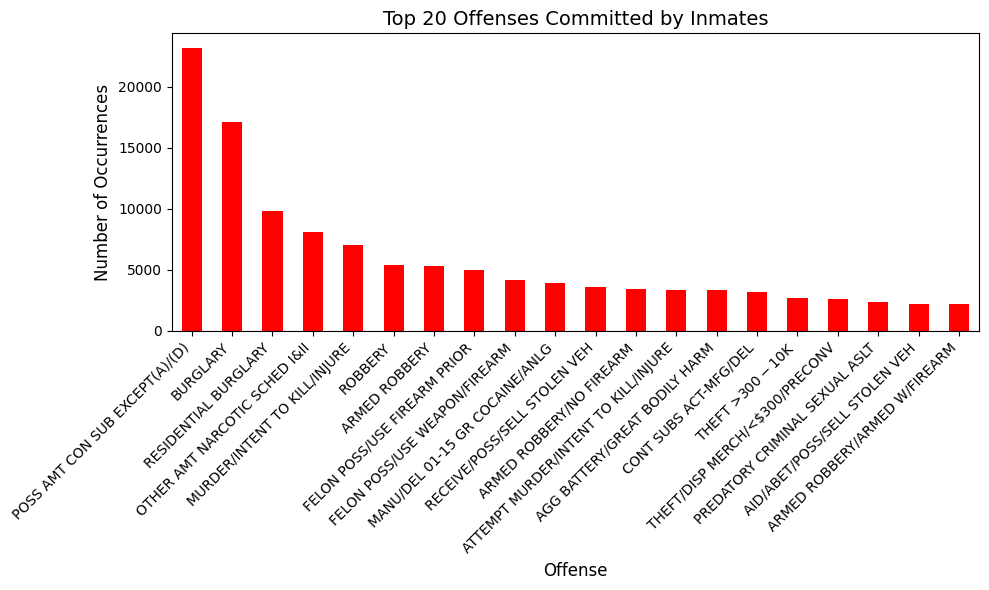

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'sentencing.csv'  # Replace with your file path
data = pd.read_csv(file_path, delimiter=';')

# Plot the distribution of offenses
plt.figure(figsize=(10, 6))
data['offense'].value_counts().head(20).plot(kind='bar', color='red')
plt.title('Top 20 Offenses Committed by Inmates', fontsize=14)
plt.xlabel('Offense', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Error loading image A:/PRML_project/side/side\A00220.jpg: cannot identify image file <_io.BytesIO object at 0x0000027302ABABB0>
Error loading image A:/PRML_project/side/side\A56106.jpg: cannot identify image file <_io.BytesIO object at 0x00000273030B8A40>
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


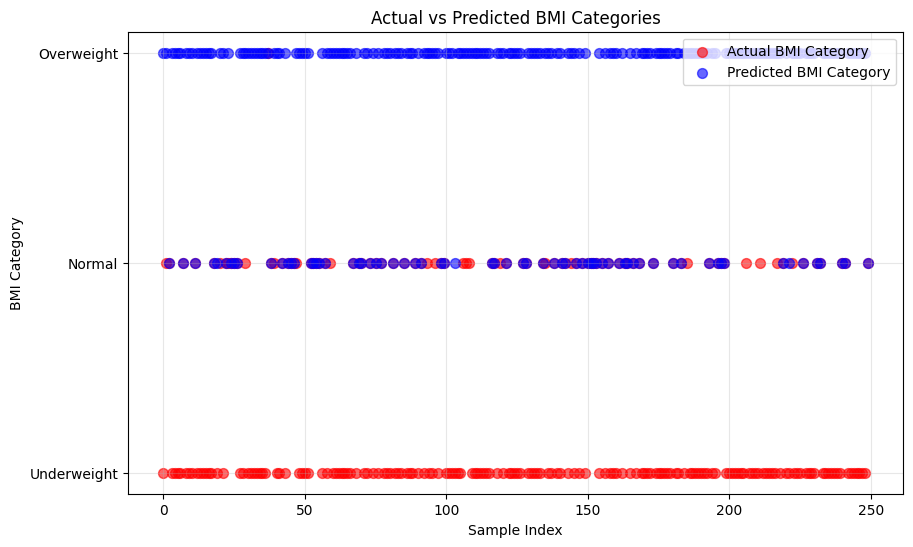

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import os

# Constants
INPUT_SHAPE = (128, 128, 3)
MODEL_PATH = 'bmi_model.h5'
SAMPLE_COUNT = 250
FRONT_IMAGES_PATH = "A:/PRML_project/front/front"
SIDE_IMAGES_PATH = "A:/PRML_project/side/side"
LABELS_PATH = "bmi.csv"  # CSV with columns ['id', 'class_label']

# Load the pre-trained model
model = load_model(MODEL_PATH)

# Load test labels
labels_df = pd.read_csv(LABELS_PATH).head(SAMPLE_COUNT)

# Load and preprocess images
def load_images(image_ids, folder_path, target_size=(128, 128)):
    images = []
    missing_files = []  # Log missing or invalid files
    for img_id in image_ids:
        img_path = os.path.join(folder_path, f"{img_id}.jpg")
        try:
            if os.path.exists(img_path):
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img) / 255.0
                images.append(img)
            else:
                missing_files.append(img_path)
                images.append(np.zeros((*target_size, 3)))  # Placeholder for missing images
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            images.append(np.zeros((*target_size, 3)))  # Placeholder for invalid images
    if missing_files:
        print(f"Missing files: {len(missing_files)}")
    return np.array(images)

# Prepare test data
image_ids = labels_df['id']
front_images = load_images(image_ids, FRONT_IMAGES_PATH, target_size=INPUT_SHAPE[:2])
side_images = load_images(image_ids, SIDE_IMAGES_PATH, target_size=INPUT_SHAPE[:2])
actual_labels = labels_df['Category']

# Make predictions
predicted_probs = model.predict([front_images, side_images])
predicted_labels = np.argmax(predicted_probs, axis=1)

# Plot predicted BMI categories vs actual BMI categories
# plt.figure(figsize=(10, 6))
# plt.hist(predicted_labels, bins=3, alpha=0.7, label='Predicted BMI Category', color='blue', align='mid')
# plt.hist(actual_labels, bins=3, alpha=0.5, label='Actual BMI Category', color='red', align='mid')
# plt.xlabel('BMI Category')
# plt.ylabel('Frequency')
# plt.title('Predicted BMI Category vs Actual BMI Category (250 Samples)')
# plt.legend(loc='upper right')
# plt.xticks([0, 1, 2], ['Underweight', 'Normal', 'Overweight'])
# plt.show()


# plt.figure(figsize=(10, 6))
# plt.scatter(actual_labels, predicted_labels, alpha=0.6, color='blue', label='Predictions')
# plt.plot([0, 2], [0, 2], linestyle='--', color='red', label='Ideal Prediction')
# plt.xlabel('Actual BMI Category')
# plt.ylabel('Predicted BMI Category')
# plt.title('Predicted vs Actual BMI Categories (250 Samples)')
# plt.xticks([0, 1, 2], ['Underweight', 'Normal', 'Overweight'])
# plt.yticks([0, 1, 2], ['Underweight', 'Normal', 'Overweight'])
# plt.grid(alpha=0.3)
# plt.legend(loc='upper left')
# plt.show()


# Scatter plot for predicted vs actual BMI categories
plt.figure(figsize=(10, 6))

# Actual BMI points
plt.scatter(range(SAMPLE_COUNT), actual_labels, color='red', label='Actual BMI Category', alpha=0.6, s=50)

# Predicted BMI points
plt.scatter(range(SAMPLE_COUNT), predicted_labels, color='blue', label='Predicted BMI Category', alpha=0.6, s=50)

# Add plot details
plt.xlabel('Sample Index')
plt.ylabel('BMI Category')
plt.title('Actual vs Predicted BMI Categories')
plt.yticks([0, 1, 2], ['Underweight', 'Normal', 'Overweight'])
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Show plot
plt.show()

